# Comparing Signal Modes for DTW Alignment

This notebook demonstrates the different **signal processing modes** available
for DTW-based cell cycle percentage estimation in FUCCIphase.

The `estimate_percentage_by_subsequence_alignment` function supports three modes:

- **`"signal"`**: Use the raw intensity signal for alignment
- **`"derivative"`**: Use the derivative of the signal (default, baseline-independent)
- **`"both"`**: Use both signal and derivative as features (richer representation)

In this notebook you will:

- Load a reference FUCCI trajectory
- Create test trajectories with different perturbations
- Compare alignment accuracy across the three signal modes
- Visualize how each mode handles intensity offsets and scaling

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from fucciphase.phase import NewColumns, estimate_percentage_by_subsequence_alignment

## Load the reference curve

In [2]:
reference_file = "../example_data/hacat_fucciphase_reference.csv"
reference_df = pd.read_csv(reference_file)

# Compute timestep from reference data
timestep = reference_df["time"][1] - reference_df["time"][0]
cyan_channel = "cyan"
magenta_channel = "magenta"

print(f"Reference data: {len(reference_df)} timepoints")
print(f"Timestep: {timestep:.3f} hours")

Reference data: 101 timepoints
Timestep: 0.197 hours


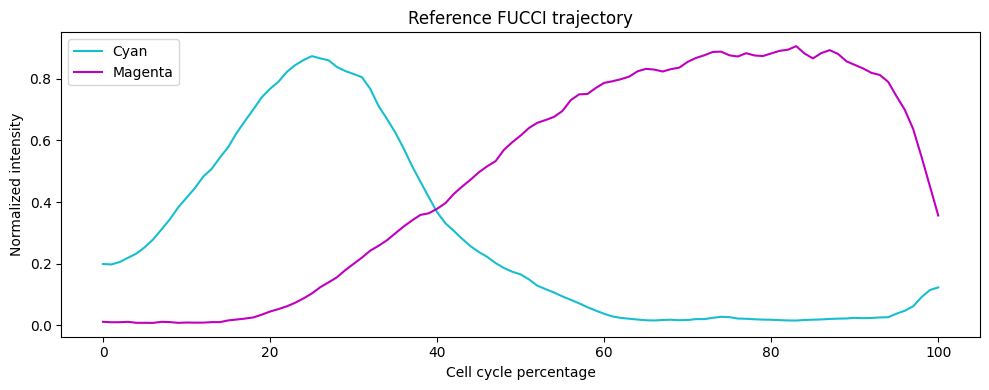

In [3]:
# Visualize the reference curve
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(
    reference_df["percentage"], reference_df["cyan"], label="Cyan", color="tab:cyan"
)
ax.plot(reference_df["percentage"], reference_df["magenta"], label="Magenta", color="m")
ax.set_xlabel("Cell cycle percentage")
ax.set_ylabel("Normalized intensity")
ax.set_title("Reference FUCCI trajectory")
ax.legend()
plt.tight_layout()
plt.show()

## Create test trajectories

We create test trajectories by extracting a subsequence from the reference
and applying different perturbations:

1. **Baseline offset**: Adding a constant to the signal
2. **Scaling**: Multiplying the signal by a factor
3. **Combined**: Both offset and scaling

In [4]:
def create_test_track(
    reference_df,
    start_idx,
    end_idx,
    cyan_offset=0,
    cyan_scale=1,
    magenta_offset=0,
    magenta_scale=1,
):
    """Create a test track from reference with perturbations."""
    df = reference_df.iloc[start_idx:end_idx].copy()
    df = df.reset_index(drop=True)
    df["TRACK_ID"] = 1

    # Apply perturbations
    df["cyan"] = df["cyan"] * cyan_scale + cyan_offset
    df["magenta"] = df["magenta"] * magenta_scale + magenta_offset

    # Store ground truth percentage
    df["ground_truth"] = df["percentage"].values

    return df

In [5]:
# Define test cases
start_idx = 20
end_idx = 70

test_cases = {
    "No perturbation": {
        "cyan_offset": 0,
        "cyan_scale": 1,
        "magenta_offset": 0,
        "magenta_scale": 1,
    },
    "Baseline offset": {
        "cyan_offset": 0.3,
        "cyan_scale": 1,
        "magenta_offset": 0.2,
        "magenta_scale": 1,
    },
    "Intensity scaling": {
        "cyan_offset": 0,
        "cyan_scale": 2.0,
        "magenta_offset": 0,
        "magenta_scale": 0.5,
    },
    "Offset + scaling": {
        "cyan_offset": 0.2,
        "cyan_scale": 1.5,
        "magenta_offset": 0.1,
        "magenta_scale": 2.0,
    },
}

## Compare signal modes

For each test case, we run the alignment with all three signal modes
and compare the results.

In [6]:
def run_alignment(df, reference_df, timestep, signal_mode):
    """Run DTW alignment with specified signal mode."""
    df_copy = df.copy()

    # Add TRACK_ID for alignment function
    df_copy["TRACK_ID"] = 1

    estimate_percentage_by_subsequence_alignment(
        df_copy,
        dt=timestep,
        channels=["cyan", "magenta"],
        reference_data=reference_df,
        track_id_name="TRACK_ID",
        signal_mode=signal_mode,
    )

    return df_copy


def compute_error(df):
    """Compute mean absolute error between ground truth and estimate."""
    estimated = df[NewColumns.cell_cycle_dtw()].values
    ground_truth = df["ground_truth"].values
    return np.nanmean(np.abs(estimated - ground_truth))


Test case: No perturbation
  signal       mode: MAE = 6.76%
  derivative   mode: MAE = 0.00%
  both         mode: MAE = 1.70%

Test case: Baseline offset
  signal       mode: MAE = 6.76%
  derivative   mode: MAE = 0.00%
  both         mode: MAE = 1.70%

Test case: Intensity scaling
  signal       mode: MAE = 6.76%
  derivative   mode: MAE = 0.00%
  both         mode: MAE = 1.70%

Test case: Offset + scaling
  signal       mode: MAE = 6.76%
  derivative   mode: MAE = 0.00%
  both         mode: MAE = 1.70%


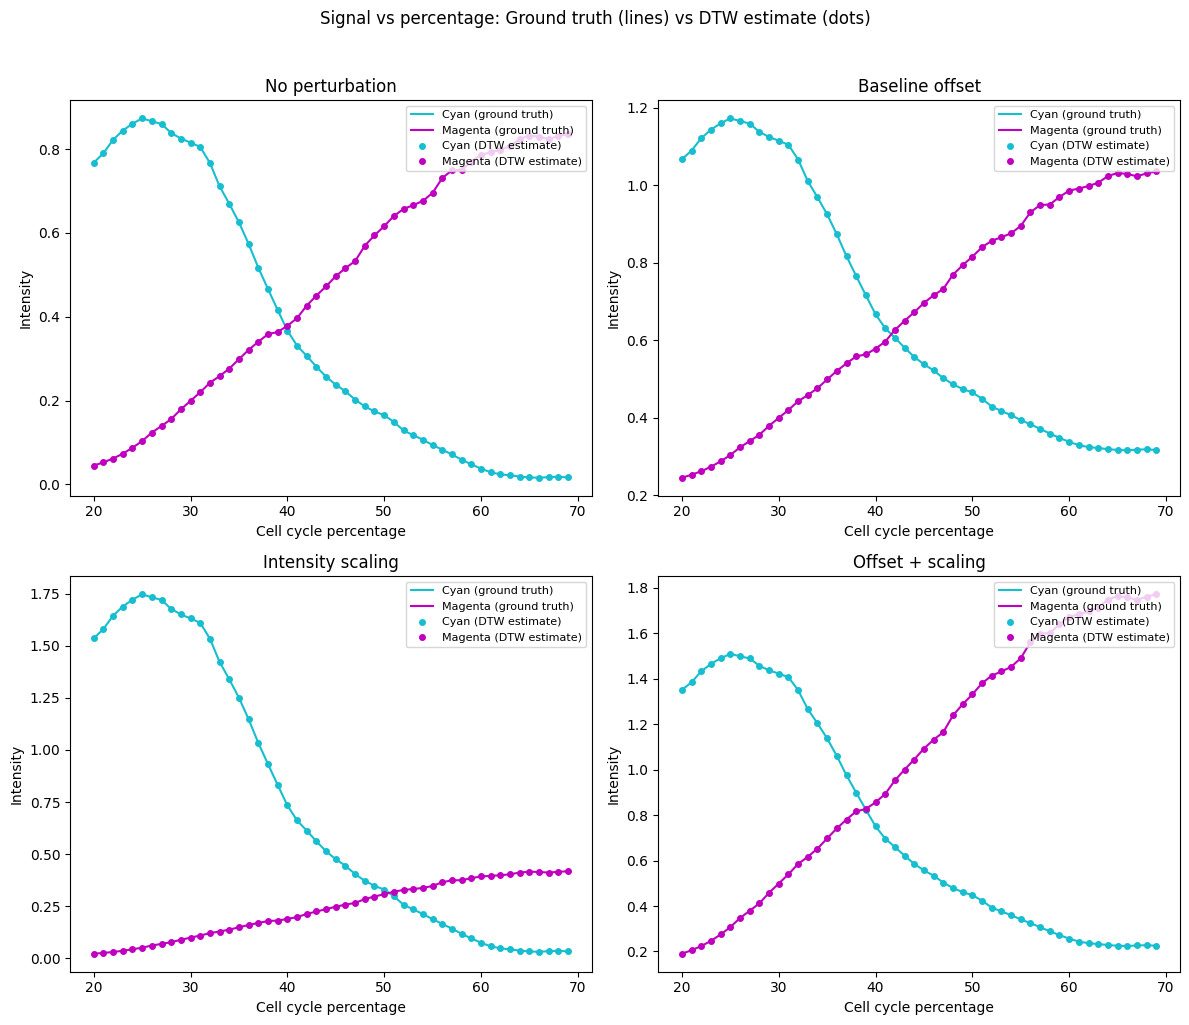

In [14]:
signal_modes = ["signal", "derivative", "both"]
results = {}

for case_name, perturbations in test_cases.items():
    print(f"\n{'='*60}")
    print(f"Test case: {case_name}")
    print(f"{'='*60}")

    # Create test track
    test_df = create_test_track(reference_df, start_idx, end_idx, **perturbations)

    results[case_name] = {}

    for mode in signal_modes:
        df_result = run_alignment(test_df, reference_df, timestep, mode)
        error = compute_error(df_result)
        results[case_name][mode] = {"df": df_result, "error": error}
        print(f"  {mode:12s} mode: MAE = {error:.2f}%")

# Visualize signal vs percentage (ground truth vs DTW estimate) for all test cases
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (case_name, case_results) in enumerate(results.items()):
    ax = axes[idx]
    df = case_results["derivative"]["df"]  # Use derivative mode (best performing)

    # Plot ground truth percentage (lines)
    ax.plot(
        df["ground_truth"], df["cyan"], "-", color="tab:cyan", label="Cyan (ground truth)"
    )
    ax.plot(
        df["ground_truth"], df["magenta"], "-", color="m", label="Magenta (ground truth)"
    )

    # Plot DTW estimated percentage (dots)
    ax.plot(
        df[NewColumns.cell_cycle_dtw()], df["cyan"], "o", color="tab:cyan",
        markersize=4, label="Cyan (DTW estimate)"
    )
    ax.plot(
        df[NewColumns.cell_cycle_dtw()], df["magenta"], "o", color="m",
        markersize=4, label="Magenta (DTW estimate)"
    )

    ax.set_xlabel("Cell cycle percentage")
    ax.set_ylabel("Intensity")
    ax.set_title(case_name)
    ax.legend(loc="upper right", fontsize=8)

plt.suptitle("Signal vs percentage: Ground truth (lines) vs DTW estimate (dots)", y=1.02)
plt.tight_layout()
plt.show()

## Visualize results

Compare the estimated percentages against ground truth for each signal mode.

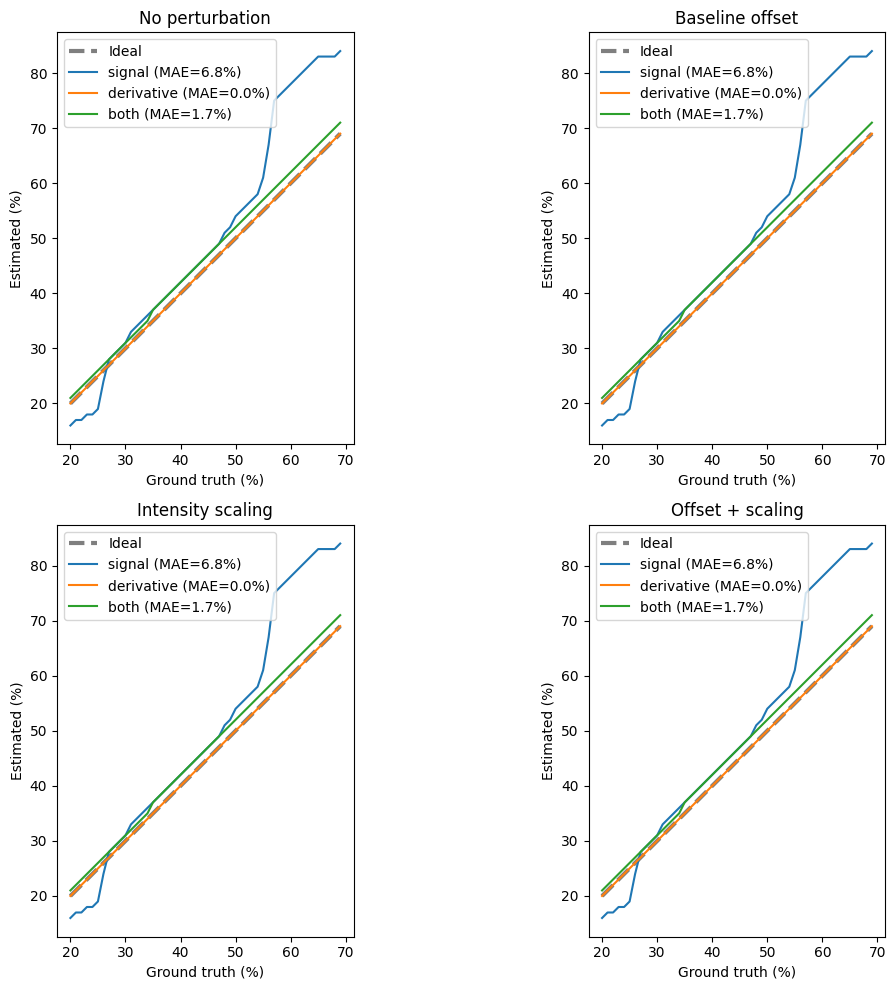

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

colors = {"signal": "tab:blue", "derivative": "tab:orange", "both": "tab:green"}

for idx, (case_name, case_results) in enumerate(results.items()):
    ax = axes[idx]

    # Get ground truth from any result (they're all the same)
    ground_truth = case_results["signal"]["df"]["ground_truth"]

    # Plot ideal line
    ax.plot(ground_truth, ground_truth, "k--", alpha=0.5, label="Ideal", lw=3)

    # Plot each signal mode
    for mode in signal_modes:
        df = case_results[mode]["df"]
        error = case_results[mode]["error"]
        estimated = df[NewColumns.cell_cycle_dtw()]
        ax.plot(
            ground_truth,
            estimated,
            color=colors[mode],
            label=f"{mode} (MAE={error:.1f}%)",
        )

    ax.set_xlabel("Ground truth (%)")
    ax.set_ylabel("Estimated (%)")
    ax.set_title(case_name)
    ax.legend(loc="upper left")
    ax.set_aspect("equal")

plt.tight_layout()
plt.savefig("signal_mode_comparison.svg")
plt.show()

## Error comparison summary

In [9]:
# Create summary table
summary_data = []
for case_name, case_results in results.items():
    row = {"Test case": case_name}
    for mode in signal_modes:
        row[f"{mode} MAE"] = f"{case_results[mode]['error']:.2f}%"
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

        Test case signal MAE derivative MAE both MAE
  No perturbation      6.76%          0.00%    1.70%
  Baseline offset      6.76%          0.00%    1.70%
Intensity scaling      6.76%          0.00%    1.70%
 Offset + scaling      6.76%          0.00%    1.70%


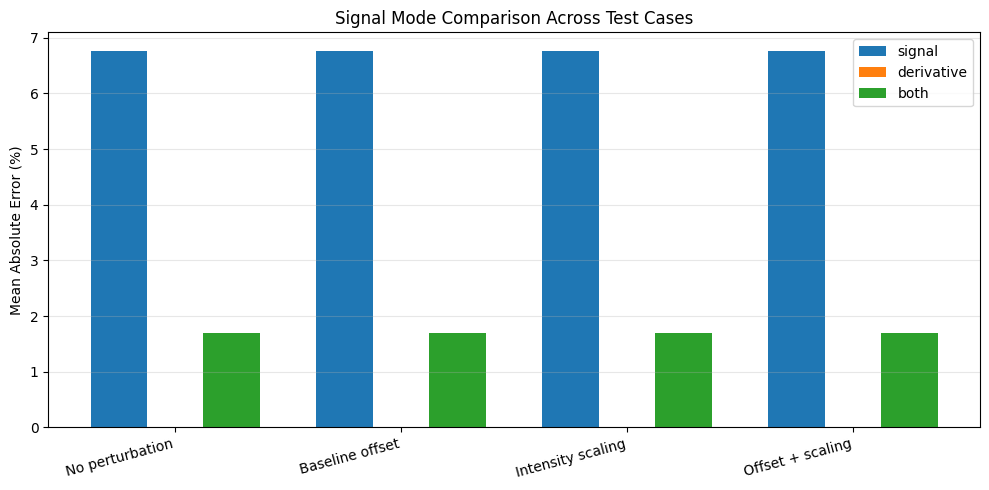

In [10]:
# Bar plot comparison
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(test_cases))
width = 0.25

for i, mode in enumerate(signal_modes):
    errors = [results[case][mode]["error"] for case in test_cases]
    ax.bar(x + i * width, errors, width, label=mode, color=colors[mode])

ax.set_ylabel("Mean Absolute Error (%)")
ax.set_title("Signal Mode Comparison Across Test Cases")
ax.set_xticks(x + width)
ax.set_xticklabels(test_cases.keys(), rotation=15, ha="right")
ax.legend()
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("signal_mode_error_bars.svg")
plt.show()

## Visualize signal processing

Let's see what the signals look like after processing in each mode.

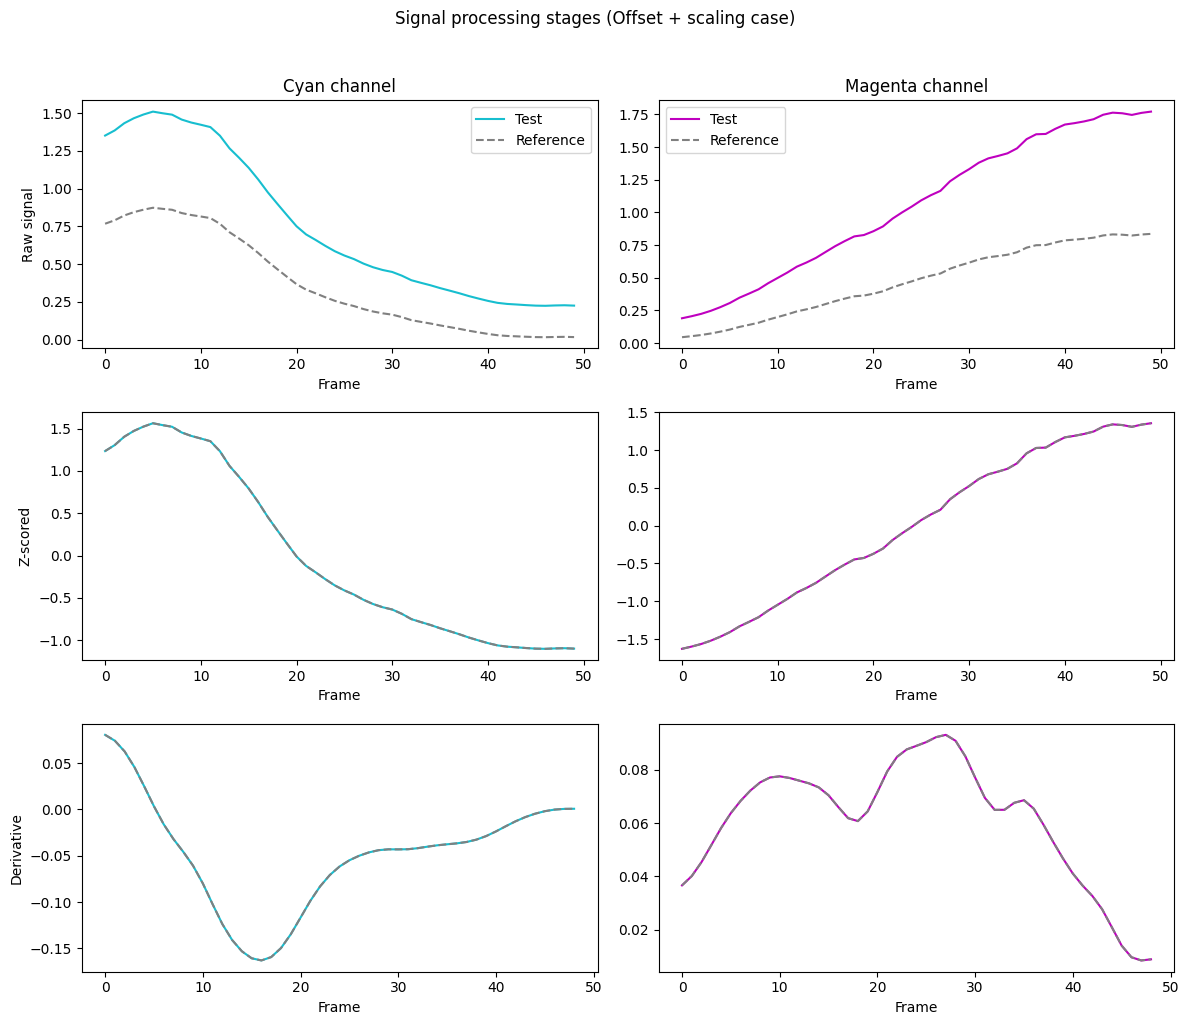

In [11]:
import dtaidistance.preprocessing
from scipy import stats

# Use the "Offset + scaling" case as example
test_df = create_test_track(
    reference_df,
    start_idx,
    end_idx,
    cyan_offset=0.2,
    cyan_scale=1.5,
    magenta_offset=0.1,
    magenta_scale=2.0,
)

fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Original signals
axes[0, 0].set_title("Cyan channel")
axes[0, 1].set_title("Magenta channel")

# Row labels
row_labels = ["Raw signal", "Z-scored", "Derivative"]
for ax, label in zip(axes[:, 0], row_labels, strict=True):
    ax.set_ylabel(label)

for col, (channel, color) in enumerate([("cyan", "tab:cyan"), ("magenta", "m")]):
    signal = test_df[channel].values
    ref_signal = reference_df.iloc[start_idx:end_idx][channel].values

    # Raw signal
    axes[0, col].plot(signal, label="Test", color=color)
    axes[0, col].plot(ref_signal, "--", label="Reference", color="gray")
    axes[0, col].legend()

    # Z-scored
    signal_z = stats.zscore(signal)
    ref_z = stats.zscore(ref_signal)
    axes[1, col].plot(signal_z, label="Test", color=color)
    axes[1, col].plot(ref_z, "--", label="Reference", color="gray")

    # Derivative
    signal_diff = dtaidistance.preprocessing.differencing(signal_z, smooth=0.1)
    ref_diff = dtaidistance.preprocessing.differencing(ref_z, smooth=0.1)
    axes[2, col].plot(signal_diff, label="Test", color=color)
    axes[2, col].plot(ref_diff, "--", label="Reference", color="gray")

for ax in axes.flatten():
    ax.set_xlabel("Frame")

plt.suptitle("Signal processing stages (Offset + scaling case)", y=1.02)
plt.tight_layout()
plt.savefig("signal_processing_stages.svg")
plt.show()

## Feature scaling in "both" mode

When using `"both"` mode, the signal and derivative features are combined for DTW alignment.
However, z-scored signals typically have std=1, while derivatives have much smaller magnitudes.
This imbalance means the signal would dominate the DTW distance calculation.

FUCCIphase automatically computes a **scale factor** to balance contributions:

```
scale_factor = std(derivative) / std(signal)
```

The signal features are then multiplied by this scale factor before DTW alignment,
ensuring both signal shape and dynamics contribute equally.

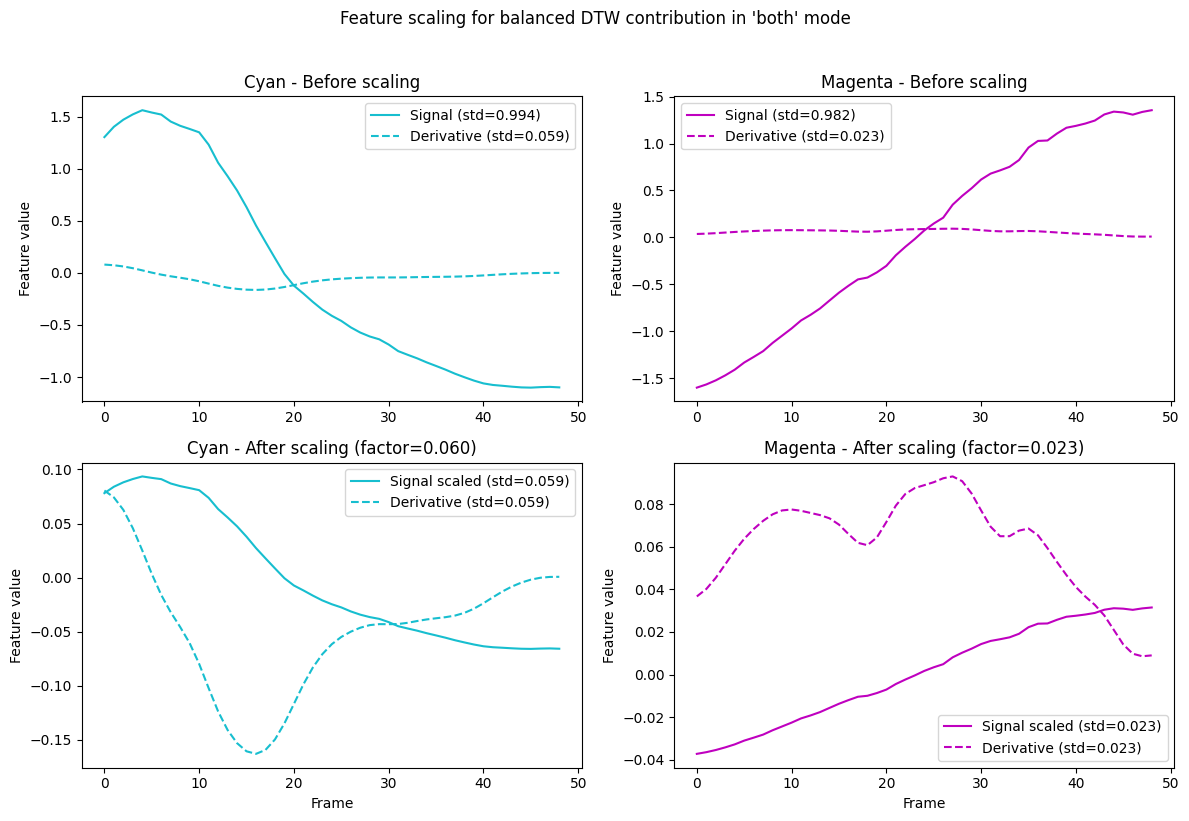


Overall statistics:
  Average signal std: 0.9883
  Average derivative std: 0.0412
  Scale factor (deriv_std / signal_std): 0.0416


In [12]:
# Demonstrate feature scaling in "both" mode
# Using reference data to show the magnitude difference

ref_subset = reference_df.iloc[start_idx:end_idx]

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for col, (channel, color) in enumerate([("cyan", "tab:cyan"), ("magenta", "m")]):
    # Z-score the signal
    signal_z = stats.zscore(ref_subset[channel].values)
    
    # Compute derivative
    derivative = dtaidistance.preprocessing.differencing(signal_z, smooth=0.1)
    
    # Trim signal to match derivative length
    signal_trimmed = signal_z[-len(derivative):]
    
    # Compute scale factor
    scale_factor = np.std(derivative) / np.std(signal_trimmed)
    signal_scaled = signal_trimmed * scale_factor
    
    # Plot unscaled features
    axes[0, col].plot(signal_trimmed, label=f"Signal (std={np.std(signal_trimmed):.3f})", color=color)
    axes[0, col].plot(derivative, label=f"Derivative (std={np.std(derivative):.3f})", color=color, linestyle="--")
    axes[0, col].set_title(f"{channel.capitalize()} - Before scaling")
    axes[0, col].legend()
    axes[0, col].set_ylabel("Feature value")
    
    # Plot scaled features
    axes[1, col].plot(signal_scaled, label=f"Signal scaled (std={np.std(signal_scaled):.3f})", color=color)
    axes[1, col].plot(derivative, label=f"Derivative (std={np.std(derivative):.3f})", color=color, linestyle="--")
    axes[1, col].set_title(f"{channel.capitalize()} - After scaling (factor={scale_factor:.3f})")
    axes[1, col].legend()
    axes[1, col].set_xlabel("Frame")
    axes[1, col].set_ylabel("Feature value")

plt.suptitle("Feature scaling for balanced DTW contribution in 'both' mode", y=1.02)
plt.tight_layout()
plt.savefig("feature_scaling_both_mode.svg")
plt.show()

# Print overall scale factor (average across channels)
all_signals = []
all_derivs = []
for channel in ["cyan", "magenta"]:
    signal_z = stats.zscore(ref_subset[channel].values)
    derivative = dtaidistance.preprocessing.differencing(signal_z, smooth=0.1)
    signal_trimmed = signal_z[-len(derivative):]
    all_signals.append(signal_trimmed)
    all_derivs.append(derivative)

avg_signal_std = np.mean([np.std(s) for s in all_signals])
avg_deriv_std = np.mean([np.std(d) for d in all_derivs])
overall_scale = avg_deriv_std / avg_signal_std

print(f"\nOverall statistics:")
print(f"  Average signal std: {avg_signal_std:.4f}")
print(f"  Average derivative std: {avg_deriv_std:.4f}")
print(f"  Scale factor (deriv_std / signal_std): {overall_scale:.4f}")

## Conclusions

- **`"derivative"`** mode (default) is robust to baseline offsets and scaling
  because it focuses on the rate of change rather than absolute values.

- **`"signal"`** mode may work well when intensities are properly normalized
  and there are no baseline shifts.

- **`"both"`** mode provides a richer feature representation by combining
  both the signal shape and its dynamics, which can improve alignment
  accuracy in some cases.